# "Socialize" = "Social" + "Optimize"
## Using Data Science to Increase Engagement on Social Media
by: Ishaan Jaffer and Jessica Chau

## Introduction
At present there are approximately 7.7 billion people in the world with at least 3.5 billion of us online, implying that social media platforms are used by approximately one-in-three people in the world. This sudden growth and adoption has transformed the way we find partners, access news and information, or even how we organize political change and in so many other different ways. Leveraging the power of social media is now more important than ever before. This project aims to optimize social media activity for our users by providing them suggestions based on the analysis of data that we get from the Twitter API. Specifically,our project will have four key features that will provide suggestions on the following: 
    1. What the best time to post on social media would be 
    2. What are some keywords to include in a tweet based on post category and trending tweets 
    3. What are some hashtags to include in a tweet based on post category and trending tweets 
    4. What is the sentiment of the tweet the user has drafted
<img src = "1.png" align = "center">
For this project, we will be focusing specifically on Twitter. We have developed these four features because these are the four main components of a tweet that a user should think about before posting it. We want to ensure that a user is posting their tweet when the most people are going to see it. Additionally, we want to provide the user with suggestions of content, including the words itself and the hashtags, that has shown to be popular. Finally, we also want to ensure that the content that the user inputted is reflecting the same sentiment that they are intending to express.


## Table of Contents
- [Architecture Diagram](#Architecture-Diagram)
- [Installing the Libraries](#Installing-the-Libraries)
- [User Input](#User-Input)
- [Gathering the Data](#Gathering-the-Data)
    - [Data Cleaning and Preprocessing](#Data-Cleaning-and-Preprocessing)
    - [Webscraping](#Webscraping)
    - [Twitter API](#Twitter-API)
- [Finding the Best Time to Post](#Finding-the-Best-Time-to-Post)
- [Providing Suggestions for Keywords and Hashtags](#Providing-Suggestions-for-Keywords-and-Hashtags)
- [Sentiment Analysis](#Sentiment-Analysis)
- [Results](#Results)
- [Suggestions for Future Research](#Suggestions-for-Future-Research)

## Architecture Diagram

Below we have illustrated the pipeline that the data will follow. With our project, we will have the user input their username, the tweet that they intend on posting, and the category or categories of the tweet that the content of their tweet falls under. With this data, we can use the Twitter API to begin building a database of all the tweets that were posted globally that fall under the category that the user inputed. We also use webscraping to build a database of all of the tweets and posts on the users timeline. Thus, for each feature of our project we can provide two suggestions, one that is based off of the global data and one that is user specific. For our global suggestion, we will analyze all of the tweets from any Twitter user globally in the given category and give a suggestion based on the data from all Twitter users in that category. For our user specific suggestion, we will analyze all of the tweets that the user has posted and give a suggestion based on only the data from the user.

With this data, we can do a time series analysis to analyze the best time for social media engagment globally for the inputted category, as well as specifically for the user. Additionally, after we have cleaned and processed the data, we can use TFIDF to analyze the most popular keywords and hashtags for all tweets globally within the given category, as well as for all of the tweets of the user. Finally, we can use a sentiment analysis model to analyze the sentiment behind the tweet that the user intends on posting.

<img src = "2.png" align = "center">

## Installing the Libraries

In order to gather the data, we will mainly be using Tweepy and the Twitter API, as well as, Selenium for webscraping. For each component of our project, we will be using different module for each component. For the time component, we will mainly be using Pandas for the time series analysis. For the keywords and hashtags, we will mainly be using the sklearn module. Finally, for the sentiment analysis, we will be using the Textblob and NLTK. 

In [301]:
import requests
import urllib
import tweepy
import json
import csv
import pandas as pd
from requests.auth import HTTPBasicAuth
import matplotlib.pyplot as plt
import re
import io
import time
from datetime import datetime
from bs4 import BeautifulSoup
import unicodedata
import string

import nltk
from nltk.corpus import stopwords
from sklearn import preprocessing
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import linear_kernel
from sklearn.metrics.pairwise import cosine_similarity



from selenium import webdriver
from selenium.webdriver.common.keys import Keys
from webdriver_manager.chrome import ChromeDriverManager

from wordcloud import WordCloud, STOPWORDS
from PIL import Image

from textblob import TextBlob
from textblob.sentiments import NaiveBayesAnalyzer
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

## User Input

We will have the user input their username or Twitter handle to us for webscraping. We will also have the user input the tweet that they intend on posting for sentiment analysis. Finally, we will have the user input the category of their tweet in order to gather data on tweets that are more relevant to the tweet that the user wants to post.

In [227]:
user_name = input("What is your username? ")

What is your username? elonmusk


In [228]:
orig_tweet_input = input("What is your tweet? ")
#"Huge thanks to all who contributed ideas to Cybertruck. It’s better because of you! ♥️♥️♥️ #Tesla #Tech2020 #Design"

What is your tweet? Huge thanks to all who contributed ideas to Cybertruck. It’s better because of you! ♥️♥️♥️ #Tesla #Tech2020 #Design


In [229]:
#Possible Categories are: Sports", "Politics", "Entertainment", "Education", "Technology", "Business"
orig_category = input("What is the category of your tweet? These are the possible categories: Sports, Politics, Entertainment, Education, Technology, Business. Please input only one category ")

What is the category of your tweet? These are the possible categories: Sports, Politics, Entertainment, Education, Technology, Business. Please input only one category Technology


##  Gathering the Data
Here is a brief overview of the entire process of gathering user data
<img src = "3.png" align = "center">
To begin with, we need to gather our data from Twitter. We will be using the Twitter API to get all of the tweets that were posted globally in the specfic inputted category. Then, we will be using webscraping to scrape the all of the posts from the user's timeline. However, in order to use the data that we have gathered, we need to clean and preprocess the data so that we can complete our analyses. The end result is two dataframes:
    1. Data Frame to analyse all tweets posted on twitter this week 
    2. Data Frame to analyse all tweets posted specificaly by the user using our product. We want to provide suggestions that are specifically curated based on our user's most popular tweets. 

### Data Cleaning and Preprocessing

Below, we have listed out all of the functions that we will need to use in our project in order to process and analyze our data. 

#### Removing emojis, special characters from tweets
In order to analyze the content of the user's intended tweet, the content of our collected tweets(using the API), and the content of the tweets on the user's timeline(done using Web Scraping), we will need to replace all characters in each tweet that are not UTF-8 with a description of the emoji

In [302]:
### replace emojis with descriptions of the emojis 
def de_emoji(tweet):
    new_tweet = ""
    emojis = []
    for character in tweet:
        try:
            character.encode("ascii")
            new_tweet += character
        except UnicodeEncodeError:
            replaced = unidecode(str(character))
            if replaced != '' and replaced !="[?]":
                new_tweet += replaced
            else:
                try:
                    emojis.append(unicodedata.name(character))
                except ValueError:
                     new_tweet += "[x]"
    return new_tweet, ",".join(emojis)
orig_tweet, orig_emojis = de_emoji(orig_tweet_input)
print("Tweet without emojis: "+orig_tweet+"\n")
print("Description of Emojis Used: "+orig_emojis)

Tweet without emojis: Huge thanks to all who contributed ideas to Cybertruck. It's better because of you!  #Tesla #Tech2020 #Design

Description of Emojis Used: BLACK HEART SUIT,VARIATION SELECTOR-16,BLACK HEART SUIT,VARIATION SELECTOR-16,BLACK HEART SUIT,VARIATION SELECTOR-16


#### Seperating tweet text, hashtags in tweets and removing stopwords, punctuation, links
When analzing tweets we want to provide user's with suggestions on what keywords to use and what hashtags to use, hence we create two seperate token lists: 
    - One for the pure text content of the tweet
    - One for the hashtags used in the tweet. 

In [303]:
lemmatizer=nltk.stem.wordnet.WordNetLemmatizer()
def preprocess(tweet):
    
    ## lowercase
    lower_case = tweet.lower()
    lower_case= re.sub("'s", "", lower_case)
    
    ## removing apostrophes
    lower_case = lower_case.translate(str.maketrans('', '', "'"))
    lower_case = lower_case.translate(str.maketrans('', '', '"'))
    
    ## remove links from tweets
    lower_case= re.sub("(http://t.co/[a-zA-Z0-9]{10})+", ",,", lower_case) 
    lower_case= re.sub("(https://t.co/[a-zA-Z0-9]{10})+", ",,", lower_case) 
    lower_case= re.sub("(twitter.com/[a-zA-Z0-9]{10})+", ",,", lower_case) 
    ## removing punctuation, only considering alphanumeric characters
    tweet_list = re.split('[^a-zA-Z0-9]', lower_case)
    
    str_list = [x for x in tweet_list if x != '']
    
    ## lemmatizing each word
    str_list = [lemmatizer.lemmatize(x) for x in str_list]
    
    ## removing stopwords
    str_list = [x for x in str_list if x not in stopwords.words('english')]
    
    ## Removing any liks that are not specifically https: links, like tesla.co or tesla.com
    str_list = [x for x in str_list if ("co" not in x) and ("com" not in x)]
    str_list = [x for x in str_list if ("co" not in x) and ("com" not in x)]
    str_list = [x for x in str_list if ("http" not in x) and ("https" not in x)]

    hashtags, mentions = [], []
    ## Creating a seperate lists for tweet texts, hashtags(#twitter), mentions(@elonmusk, @carnegiemellon)
    for word in lower_case.split():
        word = word.strip()
        if "http" not in word:
            if len(word)>0 and word[0]=="@":
                mentions.append(word)
            if len(word)>0 and word[0]=="#":
                hashtags.append(word)
    ## We would like to keep "#" but remove other punctuations
    punctuations = string.punctuation
    punctuations = punctuations.replace("#", "")
    hashtags = [x.translate(str.maketrans('', '', punctuations)) for x in hashtags]
        
            
    return str_list, hashtags, mentions
original_clean_tweet, original_hashtags, original_mentions = preprocess(orig_tweet)
print(original_clean_tweet, original_hashtags, original_mentions)

['huge', 'thanks', 'idea', 'cybertruck', 'better', 'tesla', 'tech2020', 'design'] ['#tesla', '#tech2020', '#design'] []


#### Using Our Preprocessing Functions on Our Data Frames

Before we complete any of our analyses, we will be using all of the functions in our `clean_tweets` function to break. This function cleans, processes all the tweets in the collected data frame. 

In [304]:
## Clean all tweets 
def clean_tweets(df):
    clean_tweet, hashtags, mentions, emojis = [], [], [], []
    for tweet in df['text']:
        tweet, emoji = de_emoji(tweet)
        tweet, hashtag, mention = preprocess(tweet)
        clean_tweet.append(tweet)
        hashtags.append(hashtag)
        mentions.append(mention)
        emojis.append(emoji)
    df['text'] = clean_tweet
    df['hashtags'] = hashtags
    df['mentions'] = mentions
    return df

#### Reformatting the Data

We will be using this function to reformat the time data that we are gathering from the webscraping to a DateTimeIndex format for our time series analysis. The timestamp gathered from webscraping was in string format

In [233]:
def convert24(str1): 
    # Checking if last two elements of time 
    # is AM and first two elements are 12 
    if str1[-2:] == "AM" and str1[:2] == "12": 
        return "00" + str1[2:-2]     
    # remove the AM     
    elif str1[-2:] == "AM": 
        return str1[:-2] 
    elif str1[-2:] == "PM" and str1[:2] == "12": 
        return str1[:-2] 
    else: 
        # add 12 to hours and remove PM 
        return str(int(str1[:2]) + 12) + str1[2:6] 
convert24('03:01 PM')

def convertMonth(month):
    m = {
        'Jan': 1,
        'Feb': 2,
        'Mar': 3,
        'Apr':4,
         'May':5,
         'Jun':6,
         'Jul':7,
         'Aug':8,
         'Sep':9,
         'Oct':10,
         'Nov':11,
         'Dec':12
        }
    return m[month]  

In [234]:
def format_date(user_timeline_df):
    user_timeline_df['created_at'] = user_timeline_df['created_at'].astype(str)
    for index,row in user_timeline_df.iterrows():
        #print(row['created_at'])
        dash_index = row['created_at'].find("-")
        if ":" in row['created_at'][:2]:
            time = '0' + row['created_at'][:dash_index-1]
        else:
            time = row['created_at'][:dash_index-1]
        time = convert24(time)[:-1] + ':00'
        #print(row['created_at'][index+2:])
        year = row['created_at'][dash_index+2:][-4:] + "-"
        #print(row['created_at'][dash_index+2:][-8:-5])
        month = str(convertMonth(row['created_at'][dash_index+2:][-8:-5])) + '-'
        if " " in row['created_at'][dash_index+2:][:2]:
            day = "0" + row['created_at'][dash_index+2:][0]
        else:
            day = row['created_at'][dash_index+2:][:2]
        date = year + month + day
        user_timeline_df[index:]['created_at'] = date + " " + time
    return user_timeline_df
    
#user_timeline_df = format_date(user_timeline_df)

### Webscraping
#### Scraping a user's twitter timeline based on the username
We are using Selenium to scroll through a user's timeline and scrape data. As we scrape the unstrucutred data we process each tweet using the functions described earlier and then we create a dataframe. 

#### Processing HTML content of user's twitter timeline. For each tweet on a user's timeline we scrape (Done using beautiful soup) :
    1. Tweet Content/text
    2. Number of favorites/likes the tweet received 
    3. Number of retweets the tweet receieved 

In [305]:
## Gathering relevant html content
def scraped_timeline(content, page, seen_tweets):
    soup = BeautifulSoup(page, "html.parser")
    timeline = soup.select('#timeline li.stream-item')
    ## Looping through all the tweets gathered in the current page
    for i, tweet in enumerate(timeline):
        count = tweet.select('span.ProfileTweet-actionCount')
        favs = 0.0
        retweets = 0.0
        
        ## range 1,3 as element 1 and element 2 in count are retweets and favorites 
        for j in range(1, 3):  
            elem = count[j]
            val = elem.get_text().strip()
            num = ""
            i = 0
            ## To convert the "num" to an int
            ## Numbers on twitters can be 1,200 or 10, these needed to be processed 
            while (i<len(val) and not(val[i]== " " or val[i]=="")):
                num+=val[i]
                i+=1
            if num!="":
                num = num.replace(',' , '')
                if num.isdigit():
                    if j==1:
                        retweets = int(num)
                    elif j==2:
                        favs = int(num)
        tweet_text = tweet.select('p.tweet-text')[0].get_text()
        tweet_time = tweet.select('a.tweet-timestamp')
        for elem in tweet_time:
            time = (elem.get('title')) 
        ## Add Current tweet to our dictionary of tweets 
        if tweet_text not in seen_tweets:
            seen_tweets.add(tweet.text)
            text = tweet_text
            content["created_at"].append(time)
            content["text"].append(text)
            content["favorite_count"].append(favs)
            content["retweet_count"].append(retweets)
            
    return    

#### Using Selenium (web based automation) to scroll through user's timeline 
This is done to collect more than just the first page of tweets of a user. The more data we collect the more in detail/accurate our suggestions will be. The user can also control how many tweets should be collected from their timeline by changing the "no_of_pagedowns"

In [306]:
def create_timeline_df(user_name, no_of_pagedowns=100):
    driver = webdriver.Chrome(ChromeDriverManager().install())
    browser = driver
    url = "https://twitter.com/" + user_name
    browser.get(url)
    time.sleep(1)
    elem = browser.find_element_by_tag_name("body")
    while no_of_pagedowns>=0:
        elem.send_keys(Keys.PAGE_DOWN)
        time.sleep(0.2)
        no_of_pagedowns-=1

    content = {"created_at":[], "text":[], "favorite_count":[], "retweet_count":[]}
    
    ## seen_tweets is used to ensure we do not add duplicate tweets to our dataframe
    seen_tweets = set()
    html_source = scraped_timeline(content, browser.page_source, seen_tweets)
    
    ## dataframe created from content dictionary 
    user_timeline_df = pd.DataFrame.from_dict(content)
    return user_timeline_df

#### Cleaning and preprocessing collected tweets, formatting timestamp, creating dataframe for the user's timeline

In [307]:
user_timeline_df = create_timeline_df(user_name)
clean_tweet, hashtags, mentions, emojis = [], [], [], []
for tweet in user_timeline_df['text']:
    tweet, emoji = de_emoji(tweet)
    tweet, hashtag, mention = preprocess(tweet)
    clean_tweet.append(tweet)
    hashtags.append(hashtag)
    mentions.append(mention)
    emojis.append(emoji)
user_timeline_df['text'] = clean_tweet
user_timeline_df['hashtags'] = hashtags
user_timeline_df['mentions'] = mentions
user_timeline_df['emojis'] = emojis
user_timeline_df = format_date(user_timeline_df)
user_timeline_df


Looking for [chromedriver 78.0.3904.105 mac64] driver in cache 
File found in cache by path [/Users/ishaanjaffer/.wdm/drivers/chromedriver/78.0.3904.105/mac64/chromedriver]


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


,created_at,text,favorite_count,retweet_count,hashtags,mentions,emojis
0,2019-12-11 11:25:00,"[anymore, excuse, ford, p100d, imagine, cybert...",12110,2425,"[#tesla, #cybertruckpic]","[@ford, @elonmusk]",
1,2019-12-11 09:15:00,"[edmunds, 2020, toprated, best, ev, year, tesl...",5020,767,[#toprated],[@tesla],
2,2019-12-09 10:15:00,"[tesla, virtual, power, plant, rescue, grid, p...",7280,1004,[],[],
3,2019-12-08 02:09:00,"[capture, 19, flight, space, station, dragon, ...",20670,1864,[],"[@space_station,]",
4,2019-12-07 15:56:00,"[huge, thanks, everyone, idea, cybertruck, bet...",155830,5496,[],[],
...,...,...,...,...,...,...,...
175,2019-9-28 06:31:00,"[starship, launch, facility, cameron, texas, w...",22533,3553,[],[@elonmusk],
176,2019-9-27 12:25:00,"[make, life, know, multiplanetary]",66498,3751,[],[],
177,2019-9-27 12:25:00,"[starship, allow, u, inhabit, world]",129883,11316,[],[],
178,2019-9-27 12:14:00,"[starship, half, joinedpic]",167195,20452,[],[],


Clearly Elon Musk does not use a lot of hashtags or a lot of emojis. This might be because he primarily uses twitter to update people interested in his companies. 

### Twitter API
In order to gather our data about tweets that were posted globally, we will be using Tweepy and the Twitter API. In order to do this, we needed to use an API key and access token, which we have provided in our code below. In our function `get_tweets`, we will be accessing the Twitter API using the Tweepy module. Using this module, we will begin building a CSV file that contains the most popular tweets in each of the six preset categories that we have provided from each of the last seven days. For each of these tweets, we will be getting the screen_name, the time the Tweet was posted, the content of the text, specifically the keyword tokens and the emojis, the favorite count, the retweet count, and the follower count of the author of the tweet. Thus, we use this dataset to analyze the characteristics of the most relevant and popular tweets from each of the six of the preset categories.

In [241]:

def get_tweets():
    
    ## found from Twitter Developer Account
    consumer_key = "jKh08dfgDeTPztN1rzCpTG7Ub"
    consumer_secret = "piCHq08QogdkccQjQ4w74ejfNZl0ZLJeN5QDfkyNKp1AUG1nL8"
    access_token = "968209315285946373-kB1go0AZDLjgR3uw8D04fkekvLNGrM2"
    access_secret = "49zXLZmjYPdVwIufciUGgM5vtn9YtLD4YehU6pydKCWZY"
    
    try:
        auth = tweepy.OAuthHandler(consumer_key, consumer_secret)
        auth.set_access_token(access_token, access_secret)
        api = tweepy.API(auth, wait_on_rate_limit=True)
        csvFile = open('final-project-tweets.csv', 'a')

        #Use csv writer
        csvWriter = csv.writer(csvFile)
        ## Writing the column names 
        csvWriter.writerow(["category", "screen_name", "created_at", "text", "emojis", "favorite_count", "retweet_count", "follower_count"])
        categories = ["Sports", "Politics", "Entertainment", "Education", "Technology", "Business"]
        
        ## We are also querying the keywords and hashtags used in the tweet our user entered
        categories.extend(original_clean_tweet)
        categories.extend(original_hashtags)
        print(categories)
        ## Dates for this week 
        dates = ["12-5", "12-6", "12-7", "12-8", "12-9", "12-10", "12-11"]
        for category in categories:
            print("Collecting Data for " + category)
            for date in range(len(dates)-1):
                for tweet in tweepy.Cursor(api.search,q = category,since = "2019-"+dates[date],until = "2019-"+dates[date+1],lang = "en", result_type = 'popular').items():
                    text, emojis = de_emoji(tweet.text)
                    csvWriter.writerow([category, tweet.user.screen_name, tweet.created_at, text, emojis, tweet.favorite_count, tweet.retweet_count, tweet.user.followers_count])
                    time.sleep(.200)
        csvFile.close()
    except tweepy.error.TweepError:
        raise
        
get_tweets()

['Sports', 'Politics', 'Entertainment', 'Education', 'Technology', 'Business', 'huge', 'thanks', 'idea', 'cybertruck', 'better', 'tesla', 'tech2020', 'design', '#tesla', '#tech2020', '#design']


#### Finally, we read our collected data into a dataframe and process/clean all the tweets. 

In [252]:
data = pd.read_csv("final-project-tweets.csv") 
data = clean_tweets(data)
data

,category,screen_name,created_at,text,emojis,favorite_count,retweet_count,follower_count,hashtags,mentions
0,Sports,Herve_Renard_HR,2019-12-05 21:02:58,"[player, staff, federation, ministry, sport, f...",NaN,7810,6692,153137,[],[]
1,Sports,SkySportsNews,2019-12-05 19:18:38,"[breaking, silva, ha, sacked, everton, sky, sp...",NaN,30471,7547,6980889,[],[]
2,Sports,samirasawlani,2019-12-05 13:51:18,"[horrendous, stop, read, organiser, internatio...",NaN,385,618,68095,[],[]
3,Sports,Sam4TR,2019-12-05 00:49:11,"[remember, clip, kaepernick, slinging, deep, b...",NaN,11888,4488,7635,[],[]
4,Sports,sarkodie,2019-12-05 19:26:37,"[sunday, guy, 8th, december, accra, sport, sta...","REGIONAL INDICATOR SYMBOL LETTER G,REGIONAL IN...",4343,638,2557905,[],[]
...,...,...,...,...,...,...,...,...,...,...
2026,#design,AldaCenter,2019-12-05 17:40:02,"[job, alert, please, rt, hiring, fellow, stem,...",NaN,14,17,17381,"[#scicomm, #stem]",[]
2027,#design,dribbble,2019-12-08 21:28:02,"[im, able, freelance, full, time, self, employ...",NaN,56,15,225233,[],[]
2028,#design,AudiOfficial,2019-12-09 10:00:07,"[starting, week, bang, audi, s8, r, q8, r8, rw...",NaN,563,50,423685,"[#audi, #s8,, #rs, #q8, #r8]",[]
2029,#design,interacting,2019-12-09 18:56:01,"[norman, three, level, design, visceral, behav...",NaN,48,16,38997,"[#ux, #design]",[]


## Finding the Best Time to Post 

The first feature of our project that we will explore is the prediction of the best time to post our tweets. The first step to increasing social media engagement is ensuring that your followers actually see the post. This feature is important because we want to ensure that the user will post when their tweet will gain the most exposure or when their followers are most active. In order to do this, we looked at the data from all of the tweet in the given category that we collected from the Twitter API and the data from the user's timeline that we collected from the webscraping.

### Global

In order to analyze the global data that we collected from the Twitter API, we had to process the data in such a way that we could gage the popularity of a tweet. To do this, we created a scale to measure popularity by calculating a popularity ranking to each tweet: (favorite count + retweet count) / (number of followers). This ranking would help us quantify the amount of engagement that a user has with his or her followers. From these rankings, we normalized the rankings, which would help us understand the percentage of active engagement that a user had with his or her followers in their tweet. Thus, using Pandas, in a given category, we were able to complete a time series analysis to better understand which 30 minute interval during a 24 hour period should users post to ensure the highest percentage of engagement. Through this analysis and the data we have collected, we are able to identify a 30 minute interval of when tweets were posted that users have the highest percentage of engagement with their followers. As an example, we have demonstrated if a user were to input 'Politics' as the category of their tweet. From our analysis and our plot, we could find a 30 minute interval of when 'Political' tweets had the highest social media engagment among the most popular 'Political' tweets.

In [253]:
data['created_at'] = pd.DatetimeIndex(data['created_at'])
data['created_at'] = data['created_at'].dt.time.astype(str)
data['created_at'] = pd.DatetimeIndex(data['created_at'])
data['popularity'] = (data['favorite_count'] + data['retweet_count'])/data['follower_count']

In [254]:
data.head()

,category,screen_name,created_at,text,emojis,favorite_count,retweet_count,follower_count,hashtags,mentions,popularity
0,Sports,Herve_Renard_HR,2019-12-11 21:02:58,"[player, staff, federation, ministry, sport, f...",NaN,7810,6692,153137,[],[],0.094700
1,Sports,SkySportsNews,2019-12-11 19:18:38,"[breaking, silva, ha, sacked, everton, sky, sp...",NaN,30471,7547,6980889,[],[],0.005446
2,Sports,samirasawlani,2019-12-11 13:51:18,"[horrendous, stop, read, organiser, internatio...",NaN,385,618,68095,[],[],0.014729
3,Sports,Sam4TR,2019-12-11 00:49:11,"[remember, clip, kaepernick, slinging, deep, b...",NaN,11888,4488,7635,[],[],2.144859
4,Sports,sarkodie,2019-12-11 19:26:37,"[sunday, guy, 8th, december, accra, sport, sta...","REGIONAL INDICATOR SYMBOL LETTER G,REGIONAL IN...",4343,638,2557905,[],[],0.001947


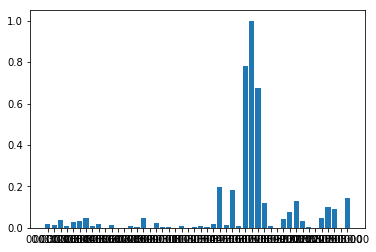

In [255]:
def get_max_time_category(category):
    groups = data.groupby(['category'])
    category = groups.get_group(category)
    time_grpr = category.groupby(pd.Grouper(key='created_at', freq='30min'))
    count_grpr = time_grpr['text'].count()
    sum_grpr = time_grpr['popularity'].sum()
    popularity = sum_grpr/count_grpr
    popularity = (popularity - popularity.min()) / (popularity.max() - popularity.min()) 
    popularity = popularity.fillna(0)
    popularity = popularity.rename('popularity')
    popularity_df = popularity.to_frame()
    popularity_df['tmpstmp'] = popularity.index
    popularity_df['tmpstmp'] = popularity_df['tmpstmp'].dt.time.astype(str)
    plt.bar(popularity_df['tmpstmp'],height = popularity_df['popularity'])
    max_time = popularity_df['popularity'].idxmax()
    return max_time

best_time_to_post = get_max_time_category(orig_category)

### User Specific

In order to analyze the user specific data that we collected from the webscraping, we had to process the data in such a way that we could gage the popularity of a tweet. To do this, we used the same scale to measure the popularity of a tweet as we did in the previous section for the the global tweets. For a specific user, we analyzed all of the posts that the user had on his or her timeline. Using this data, we are able to measure when their posts had the highest percentage of active engagment with his or her followers. Thus, using Pandas, we are able to complete a time series analysis to better understand which 10 minute interval during a 24 hour period should the user post to ensure the highest percentage of engagement. Through this analysis and the data we have collected, we are able to identify a 10 minute interval of when the user's tweets had the highest percentage of engagement with their followers. As an example, we have demonstrated if the user's username was 'elonmusk', we would be able to demonstrate when his tweets have historically had the highest percentage of engagement with his followers.

In [256]:
consumer_key = "jKh08dfgDeTPztN1rzCpTG7Ub"
consumer_secret = "piCHq08QogdkccQjQ4w74ejfNZl0ZLJeN5QDfkyNKp1AUG1nL8"
access_token = "968209315285946373-kB1go0AZDLjgR3uw8D04fkekvLNGrM2"
access_secret = "49zXLZmjYPdVwIufciUGgM5vtn9YtLD4YehU6pydKCWZY"
auth = tweepy.OAuthHandler(consumer_key, consumer_secret)
auth.set_access_token(access_token, access_secret)
api = tweepy.API(auth, wait_on_rate_limit=True)
user = api.get_user(user_name)
follower_count = user.followers_count

In [257]:
user_timeline_df['created_at'] = user_timeline_df['created_at'].astype(str)
user_timeline_df['created_at'] = pd.DatetimeIndex(user_timeline_df['created_at'])
user_timeline_df['created_at'] = user_timeline_df['created_at'].dt.time.astype(str)
user_timeline_df['created_at'] = pd.DatetimeIndex(user_timeline_df['created_at'])
user_timeline_df['popularity'] = (user_timeline_df['favorite_count'] + user_timeline_df['retweet_count'])/follower_count
user_timeline_df['popularity'] = (user_timeline_df['popularity'] - user_timeline_df['popularity'].min()) / (user_timeline_df['popularity'].max() - user_timeline_df['popularity'].min())
user_timeline_df.head()

,created_at,text,favorite_count,retweet_count,hashtags,mentions,emojis,popularity
0,2019-12-11 11:25:00,"[anymore, excuse, ford, p100d, imagine, cybert...",11181,2269,"[#tesla, #cybertruckpic.,,]","[@ford, @elonmusk]",,0.012462
1,2019-12-11 09:15:00,"[edmunds, 2020, toprated, best, ev, year, tesl...",4894,751,[#toprated],[@tesla],,0.002601
2,2019-12-11 10:15:00,"[tesla, virtual, power, plant, rescue, grid, p...",7276,1003,[],[],,0.005929
3,2019-12-11 02:09:00,"[capture, 19, flight, space, station, dragon, ...",20657,1864,[],"[@space_station,]",,0.023923
4,2019-12-11 15:56:00,"[huge, thanks, everyone, idea, cybertruck, bet...",155782,5496,[],[],,0.199230


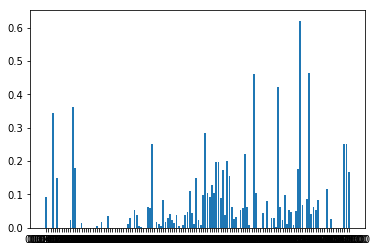

In [258]:
def get_max_time_user():
    user_time_grpr = user_timeline_df.groupby(pd.Grouper(key='created_at', freq='10min'))
    user_count_grpr = user_time_grpr['text'].count()
    user_sum_grpr = user_time_grpr['popularity'].sum()
    user_popularity = user_sum_grpr/user_count_grpr
    user_popularity = user_popularity.fillna(0)
    user_popularity = user_popularity.rename('popularity')
    user_popularity_df = user_popularity.to_frame()
    user_popularity_df['tmpstmp'] = user_popularity.index
    user_popularity_df['tmpstmp'] = user_popularity_df['tmpstmp'].dt.time.astype(str)
    plt.bar(user_popularity_df['tmpstmp'],height = user_popularity_df['popularity'])
    user_max_time = user_popularity_df['popularity'].idxmax()
    return user_max_time

best_time_to_post_user = get_max_time_user()

## Providing Suggestions for Keywords and Hashtags
In order to provide suggestions we attempt to analyse the data collected and identify patterns/trends in the most popular tweets. For the purpose of this project we defined popularity of a tweet based on the following: 
1. User/Follower Engagement: This is the number of likes/favorites and retweets a particular tweet receieves. We divide this by the total number of followers a user has to give use the "Likes ratio" as Gen-Z refers to it. This is done because some users can have 10Million followers but their post only receives 1000 likes, whereas if a user with 1000 followers receives 1000 likes on a post that post definitely has something more significant or interesting to their followers compared to the post that received 1000 likes from 10Million followers. This method of defining popularity of a tweet provides us with a relative score("ranking") for each tweet and the author of that tweet.
2. Number of days since the tweet was posted. This week's trends might be very different from last week's trends or trends 1 hour ago might be very different from trends in the present. Consider the fact that this year "Trump" was one of the most trending words on twitter, this might not have been this case before he announced his campaign. 
3. How similar the tweet is to the original tweet entered by the user i.e the tweet the end user of our project wants to optimise. We want our suggestions to be related to what our user is posting about. For example if our user was going to post about their new truck we do not want to suggest to them to include words like "politics" or "corruption". 

In [259]:
def make_rankings(data, mode):
    ## creating a ranking column
    if mode=="user":
        data['ranking'] = (data['retweet_count'] + data['favorite_count'])
    else:
        data['ranking'] = (data['retweet_count'] + data['favorite_count'])/data['follower_count']
    ## normalising the ranking columns
    x = data[['ranking']].values.astype(float)
    min_max_scaler = preprocessing.MinMaxScaler()
    x_scaled = min_max_scaler.fit_transform(x)
    data['ranking'] = 100*pd.DataFrame(x_scaled)
    return 
make_rankings(data,"regular")

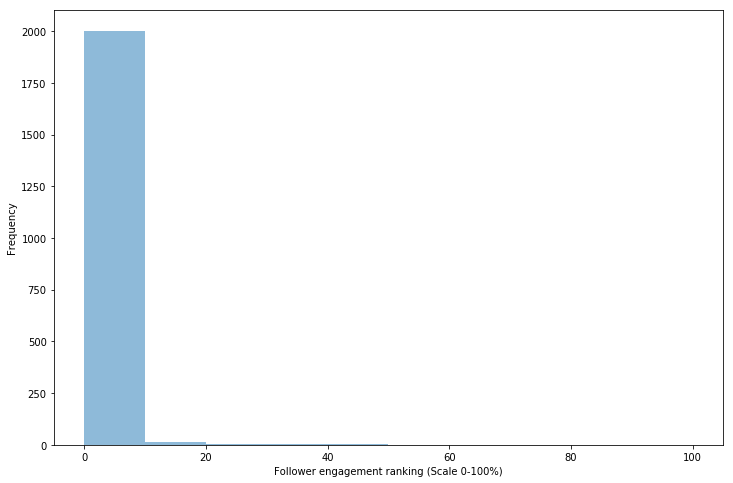

In [260]:
## Visualising Rankings of our collected users 
fig = plt.figure(figsize = (12,8))
ax = fig.gca()
ax.set_xlabel("Follower engagement ranking (Scale 0-100%)")
ax.set_ylabel("Number of posts with ranking")
data['ranking'].plot.hist(bins=10, alpha=0.5, ax=ax)

A majority of people on twitter have very poor engagement for their followers. A great reason to start using our project in the market. The benefits of high user/follower engagement can include higher income, higher popularity and even higher happiness for our users. 

### Number of Seconds Since Each Tweet was Posted
This accounts for the fact that social media trends today are not the same as they were last week or last year. We will calculate the time it has been between this present moment and the tweet timestamp. This information is stored in the num_seconds column in our dataframe. 

In [261]:
def make_num_seconds(data):
    now = datetime.now()
    diff = []
    data['created_at'] = pd.to_datetime(data['created_at'])
    time_diff = (now - data['created_at'])
    for elem in time_diff:
        diff.append(elem.total_seconds())
    data['num_seconds'] = diff
    return data
data = make_num_seconds(data)
data.head()

,category,screen_name,created_at,text,emojis,favorite_count,retweet_count,follower_count,hashtags,mentions,popularity,ranking,num_seconds
0,Sports,Herve_Renard_HR,2019-12-11 21:02:58,"[player, staff, federation, ministry, sport, f...",NaN,7810,6692,153137,[],[],0.094700,1.449749,7828.002644
1,Sports,SkySportsNews,2019-12-11 19:18:38,"[breaking, silva, ha, sacked, everton, sky, sp...",NaN,30471,7547,6980889,[],[],0.005446,0.083340,14088.002644
2,Sports,samirasawlani,2019-12-11 13:51:18,"[horrendous, stop, read, organiser, internatio...",NaN,385,618,68095,[],[],0.014729,0.225462,33728.002644
3,Sports,Sam4TR,2019-12-11 00:49:11,"[remember, clip, kaepernick, slinging, deep, b...",NaN,11888,4488,7635,[],[],2.144859,32.836266,80655.002644
4,Sports,sarkodie,2019-12-11 19:26:37,"[sunday, guy, 8th, december, accra, sport, sta...","REGIONAL INDICATOR SYMBOL LETTER G,REGIONAL IN...",4343,638,2557905,[],[],0.001947,0.029777,13609.002644


### Similarity Between Original Tweet and Each Tweet in Dataframe
To compare to tweets we are calculating the cosine similarity between to tweets. Before we can calculate the cosine similarity we need to use a TF-IDF(Term Frequency Inverse Document Frequency) Vectorizer to create a Matrix for the features of each tweet and a Matrix for the features of the user's entered tweet. To create a TF-IDF vectorizer was collect all the words and hashtags in our collected dataset and use that as our vocabulary i.e the tfidf vectorizer is fit to it. We then create feature vectors for tweet_1 and tweet_2. These are Sparse Matrices that need to be compared row by row to find the cosine difference

Once we have two matrices (one for the original tweet and one for a tweet in our dataframe), cosine similarity is calculated between two vectors. 
The cosine similarity is calculated in the following way for two vectors x,y
<img src = "imgs/cs.png" align = "center">

In [308]:
## Since tweet_1 and tweet_2 are tokenized lists we need a function that does nothing to use tfidf on lists
def do_nothing(x):
    return x


## comparing tweet_2 to the original tweet written by the user 
def similarity(tweet_1, tweet_2, tfidf):
    if len(tweet_2)==0:
        return 0.0
    features_orig = tfidf.transform(tweet_1)
    features_current = tfidf.transform(tweet_2)
    cosine = (cosine_similarity(features_orig, features_current))
    cosine_total = 0.0
    for row in cosine:
        cosine_total+= sum(row)
    return cosine_total

def creat_similarities(data):
    similarities = []
    ## Creating our vocabulary consisting of all words in tweets and hashtags collected 
    words =[]
    for row in data['text']:
            words.append(list(set(row)))
    for row in data['hashtags']:
        words.append(list(set(row)))
        
    ## Create tfidf vectorizer based on collected vocabulary
    tfidf = TfidfVectorizer(tokenizer=do_nothing,preprocessor=do_nothing)
    tfidf.fit(words)
    
    ## Compare similarity of each tweet in dataframe to user tweet 
    for text in data['text']:
        similarities.append(similarity(original_clean_tweet, text, tfidf))
    for i, hash_tag in enumerate(data['hashtags']):
        ## only compare hashtags if both tweet1 and tweet2 have hashtags
        if len(hash_tag)>0 and len(original_hashtags)>0:
            similarities[i]+= similarity(original_hashtags, hash_tag, tfidf)
    data['similarity'] = similarities
    data['similarity'].fillna(0)
    return 
creat_similarities(data)
print("The results of our cosine similarity")
print("Two tweets that are similar: hello carnegie mellon how vs hi carnegie mellon university how are")
print(similarity(["hello", "carnegie", "mellon", "how"], ["hi", "carnegie", "mellon", "university", "how", "are"], tfidf))
print("Two tweets that are different: hello carnegie mellon how vs bye mit reject me again")
print(similarity(["hello", "carnegie", "mellon", "how"], ["bye", "mit", "reject", "me", "again"], tfidf))

The results of our cosine similarity
Two tweets that are similar: hello carnegie mellon how vs hi carnegie mellon university how are
9.15761549577
Two tweets that are different: hello carnegie mellon how vs bye mit reject me again
5.07016626013


In [309]:
data

,category,screen_name,created_at,text,emojis,favorite_count,retweet_count,follower_count,hashtags,mentions,popularity,ranking,num_seconds,similarity
0,Sports,Herve_Renard_HR,2019-12-11 21:02:58,"[player, staff, federation, ministry, sport, f...",NaN,7810,6692,153137,[],[],0.094700,1.449749,7828.002644,18.033894
1,Sports,SkySportsNews,2019-12-11 19:18:38,"[breaking, silva, ha, sacked, everton, sky, sp...",NaN,30471,7547,6980889,[],[],0.005446,0.083340,14088.002644,21.595309
2,Sports,samirasawlani,2019-12-11 13:51:18,"[horrendous, stop, read, organiser, internatio...",NaN,385,618,68095,[],[],0.014729,0.225462,33728.002644,20.723786
3,Sports,Sam4TR,2019-12-11 00:49:11,"[remember, clip, kaepernick, slinging, deep, b...",NaN,11888,4488,7635,[],[],2.144859,32.836266,80655.002644,28.929002
4,Sports,sarkodie,2019-12-11 19:26:37,"[sunday, guy, 8th, december, accra, sport, sta...","REGIONAL INDICATOR SYMBOL LETTER G,REGIONAL IN...",4343,638,2557905,[],[],0.001947,0.029777,13609.002644,15.256162
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2026,#design,AldaCenter,2019-12-11 17:40:02,"[job, alert, please, rt, hiring, fellow, stem,...",NaN,14,17,17381,"[#scicomm, #stem]",[],0.001784,0.027270,20004.002644,22.269463
2027,#design,dribbble,2019-12-11 21:28:02,"[im, able, freelance, full, time, self, employ...",NaN,56,15,225233,[],[],0.000315,0.004791,6324.002644,35.677633
2028,#design,AudiOfficial,2019-12-11 10:00:07,"[starting, week, bang, audi, s8, r, q8, r8, rw...",NaN,563,50,423685,"[#audi, #s8,, #rs, #q8, #r8]",[],0.001447,0.022115,47599.002644,20.074490
2029,#design,interacting,2019-12-11 18:56:01,"[norman, three, level, design, visceral, behav...",NaN,48,16,38997,"[#ux, #design]",[],0.001641,0.025090,15445.002644,30.028940


### Finding the Keywords and Hashtags Using Our Rankings
We create a dictionary for each word in our dataset and another dictionary for each hashtag in our dataset. Each key in both dictionaries has a score associated with it. When assigning scores to keywords or hashtags we considered the following: 
1. Higher "ranking" or higher (number of likes/favorites + number of retweets)/(number of followers) is better than a lower ranking. Hence this should be added to the words 
2. Higher similarity is a positive weight, hence this is also added to each word score 
3. Lower time is a positive weight. The more recent a tweet is the higher likelihood of it containing a recent trend. Hence we divide the score of a word by num_seconds. Words used more recently should have higher scores. 

In [323]:
def find_keywords_hashtags(data):
    keywords = {}
    hashtags = {}
    for index, row in data.iterrows():
        tweet = row["text"]
        for word in tweet:
            if word in keywords:
                keywords[word]+= (row["similarity"]+row["ranking"])/row["num_seconds"]
            else:
                keywords[word] = (row["similarity"]+row["ranking"])/row["num_seconds"]
        for tag in row["hashtags"]:
            if tag in hashtags:
                hashtags[tag] += (row["similarity"]+row["ranking"])/row["num_seconds"]
            else:
                hashtags[tag] = (row["similarity"]+row["ranking"])/row["num_seconds"]

    best_words = {k: v for k, v in sorted(keywords.items(), key=lambda item: item[1], reverse=True)}
    best_tags = {k: v for k, v in sorted(hashtags.items(), key=lambda item: item[1], reverse=True)} 
    
    best_words_list = []
    best_tags_list = []
    for elem in best_words:
        best_words_list.append(elem)
    for elem in best_tags:
        best_tags_list.append(elem)
    
    
    return best_words, best_tags, best_words_list, best_tags_list

## Visualising Our Results
We create wordclouds for our list of suggestions. The bigger a word is on the chart the more likely it is to be used. These suggestions are based on the original tweet at the start of this project:
"Huge thanks to everyone who contributed ideas to Cybertruck. It’s better because of you! ♥️♥️♥️ #Tesla #Tech2020 #Design"

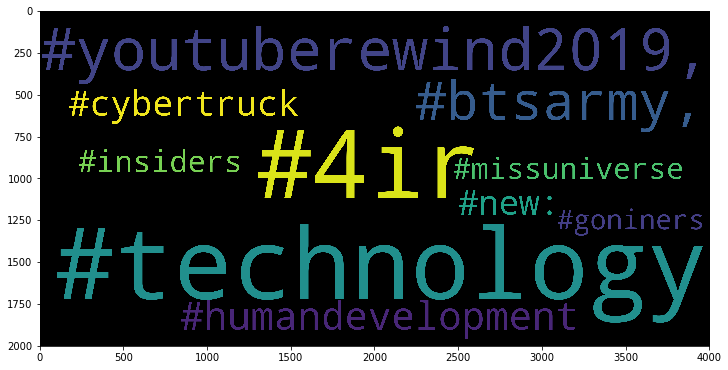

In [325]:
best_keywords, best_hashtags, best_words_list, best_tags_list = find_keywords_hashtags(data)
fig = plt.figure(figsize = (12,8))
wc = WordCloud(background_color="black",width=4000,height=2000, max_words=10,relative_scaling=0.5,normalize_plurals=False).generate_from_frequencies(best_hashtags)
plt.imshow(wc)

youtuberewind2019, cybertruck, technology, insiders, new all seem like good suggestions to the original tweet. There are still some unrelated suggestions like 4ir, missuniverse

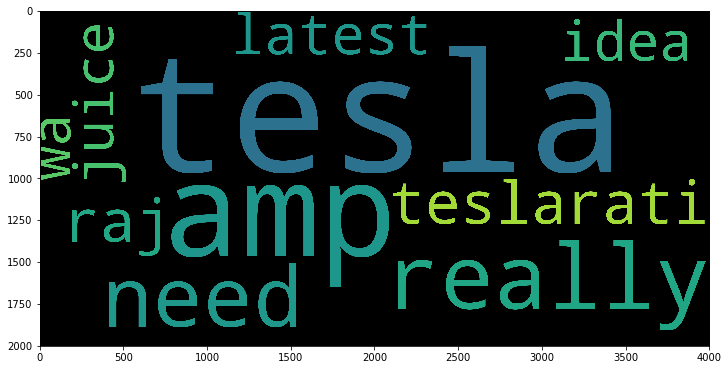

In [285]:
fig = plt.figure(figsize = (12,8))
wc = WordCloud(background_color="black",width=4000,height=2000, max_words=10,relative_scaling=0.5,normalize_plurals=False).generate_from_frequencies(best_keywords)
plt.imshow(wc)

Hmm teslarati ? I guess the world really likes teslaratis. 
Once again latest, tesla, teslarati, amp juice(like car battery juice)seem like relevant and good suggestions but raj and wa seem to be not to useful for our original tweet.

## Keyword and Hashtag Suggestions Based on Users Timeline Dataframe

In [326]:
user_timeline_df['created_at'] = pd.to_datetime(user_timeline_df ['created_at'])
creat_similarities(user_timeline_df)
make_num_seconds(user_timeline_df)
make_rankings(user_timeline_df, "user")
best_keywords_user, best_hashtags_user, best_words_list_user, best_tags_list_user = find_keywords_hashtags(user_timeline_df)

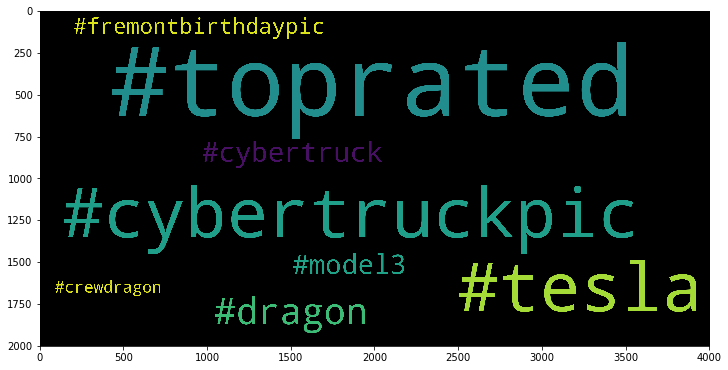

In [317]:
fig = plt.figure(figsize = (12,8))
wc = WordCloud(background_color="black",width=4000,height=2000, max_words=8,relative_scaling=0.5,normalize_plurals=False).generate_from_frequencies(best_hashtags_user)
plt.imshow(wc)

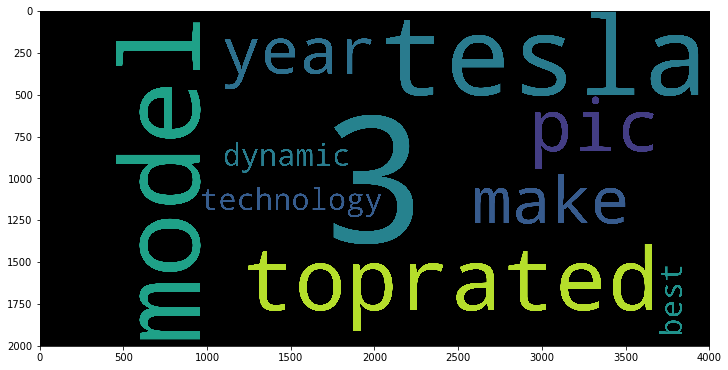

In [318]:
fig = plt.figure(figsize = (12,8))
wc = WordCloud(background_color="black",width=4000,height=2000, max_words=10,relative_scaling=0.5,normalize_plurals=False).generate_from_frequencies(best_keywords_user)
plt.imshow(wc)

Elon Musk does not use a lot of hashtags in his tweets. It most likely is the case that from all the tweets we collected #toprated was the only one he ever used. 

## Sentiment Analysis

In order to provide the user with insights about the sentiment of their tweets we are using two pre built sentiment classifiers: 
1. Vader (Valence Aware Dictionary and sEntiment Reasoner)
2. TextBlob
We then combine the results of both these classifiers to provide the user with a more in detail result. We are using two classifiers because Vader is better suited for social media content as it considers the fact that sentiment of a sentence changes based on emoticons, capitalization or slang(more commonly seen on social media). 
Vader can provide us with the degree/magnitude of positivity, negativity or neutrality of a text. 
Example: "Hello this is nice", scores={pos:.80, neg: .1, neu: .2}

Textblob provides us with the polarity of a sentence i.e scores in range -1 & 1 but we are not given the degree of how neutral a sentence is. These results are then combined with the vader scores to provide the user with an average score from both classifiers. 

Our users can see the sentiment of the following: 
1. Their original tweet
2. The emojis they are using in the original tweet. Since a lot of users not part of Gen-Z might not actually understand the sentiment of some emojis. 
3. The hashtags they are using in their original tweet. 

In [290]:
## Vader Sentiment Analyser
vader_analyser = SentimentIntensityAnalyzer()
def sentiment_analyzer_scores(sentence):
    score_vader = analyser.polarity_scores(sentence)
    score_text_blob = TextBlob(sentence).sentiment.polarity
    if score_text_blob>0:
        score_vader['pos']=(score_text_blob+score_vader['pos'])/2
    if score_text_blob<0:
        score_vader['neg'] =(abs(score_text_blob)+score_vader['neg'])/2
    result = "This text is "+ str(score_vader['pos']*100) +"% Positive, " + str(score_vader['neu']*100) +"% Neutral, " + str(score_vader['neg']*100) + "% Negative "
    return result

final_sentiment ="The Sentiment of the original tweet:\n"
final_sentiment+=(sentiment_analyzer_scores(orig_tweet_input)+"\n")
final_sentiment+="The Sentiment of the emojis in the original tweet:\n"
final_sentiment+= (sentiment_analyzer_scores(orig_emojis)+"\n")
final_sentiment+="The Sentiment of the hashtags in the original tweet:\n"
final_sentiment+= sentiment_analyzer_scores(",".join(original_hashtags))
print(final_sentiment)

The Sentiment of the original tweet:
This text is 38.366666666666674% Positive, 64.1% Neutral, 0.0% Negative 
The Sentiment of the emojis in the original tweet:
This text is 0.0% Positive, 100.0% Neutral, 8.333333333333332% Negative 
The Sentiment of the hashtags in the original tweet:
This text is 0.0% Positive, 100.0% Neutral, 0.0% Negative 


## Results

Now that we have explored all of the features of our project, here are the final results of our project. In order to demonstrate how all of the features of our project work together, we have created an example input to demonstrate a sample response that our project would give. 

For our example, our user is Elon Musk and his username is 'elonmusk' and he is looking to post this tweet: 'Huge thanks to everyone who contributed ideas to Cybertruck. It’s better because of you! ♥️♥️♥️ #Tesla #Tech2020 #Design'. He has also indicated that the tweet that the category of his tweet is 'Technology'.

To begin, our application will gather the data from the user's timeline and will gather data regarding the tweets in the given category.

In [343]:
best_words_list, best_tags_list
table = {"Suggestions":["Best Time to post", "Best keywords to use", "Best hashtags to use"], 
         "All Collected Twitter Data": [str(best_time_to_post),str(best_words_list), str(best_tags_list)], 
         "User's Timeline Twitter Data":[str(best_time_to_post_user), str(best_words_list_user), str(best_tags_list_user)]}
table = pd.DataFrame.from_dict(table)
pd.set_option('display.width', 5000)
pd.set_option('display.expand_frame_repr', True)

In [344]:
table

,Suggestions,All Collected Twitter Data,User's Timeline Twitter Data
0,Best Time to post,2019-12-11 16:00:00,2019-12-11 19:20:00
1,Best keywords to use,"['tesla', 'amp', 'really', 'need', 'teslarati'...","['3', 'tesla', 'model', 'toprated', 'pic', 'ma..."
2,Best hashtags to use,"['#technology', '#4ir', '#youtuberewind2019,',...","['#toprated', '#cybertruckpic', '#tesla', '#dr..."


## The Sentiment of your Tweet

In [322]:
print(final_sentiment)

The Sentiment of the original tweet:
This text is 38.366666666666674% Positive, 64.1% Neutral, 0.0% Negative 
The Sentiment of the emojis in the original tweet:
This text is 0.0% Positive, 100.0% Neutral, 8.333333333333332% Negative 
The Sentiment of the hashtags in the original tweet:
This text is 0.0% Positive, 100.0% Neutral, 0.0% Negative 


Thus, we have provided four suggestions regarding important factors that a user should consider before posting their tweet. With our application, the user should get much higher social media engagment on each of their tweets if they take our suggestions into consideration. With these suggestions, the user can now identify the best time to post their tweets regarding the category of the content of their tweet, what keywords or hashtags to include, and if the sentiment of their tweet is the same as the sentiment that they are aiming to express.

## Suggestions for Future Research

With more resources and access to data, we would look to actually test our application to ensure that our suggestions can actually improve social media engagement on a user's tweets. We would also suggest adding different methods to calculate the similarity between tweets. Additionally, we would suggest expanding our application to other social media platforms such as Instagram, Facebook, LinkedIn, and etc. We would also suggest expanding our application to analyze the content of images included in a social media post.

For additional references and details, here is the documentation for the important modules that were used in this project:
- Tweepy: [https://www.tweepy.org/](https://www.tweepy.org/)
- Selenium: [https://selenium-python.readthedocs.io/](https://selenium-python.readthedocs.io/)
- Pandas: [https://pandas.pydata.org/](https://pandas.pydata.org/)
- sklearn: [https://scikit-learn.org/stable/](https://scikit-learn.org/stable/)
- TextBlob: [https://textblob.readthedocs.io/en/dev/](https://textblob.readthedocs.io/en/dev/)

